In [2]:
import pandas as pd
import re
from collections import defaultdict

# Load the files
leaders_df = pd.read_csv('leader_party_updated.csv')
tweets_df = pd.read_csv('5500_tweet.csv')

# Get unique leader entities
leader_entities = leaders_df['entity'].tolist()

print(f"Total leader entities to search: {len(leader_entities)}\n")

# Function to create proper name patterns for matching
def create_name_patterns(entity):
    """
    Convert entity names to proper search patterns
    Handles camelCase, underscores, and compound names
    """
    # Remove common prefixes
    entity_clean = re.sub(r'^(npm|pm|cm)', '', entity, flags=re.IGNORECASE)
    
    # Split by camelCase: "tejashwiYadav" -> "tejashwi yadav"
    entity_spaced = re.sub(r'([a-z])([A-Z])', r'\1 \2', entity_clean)
    
    # Replace underscores with spaces
    entity_spaced = entity_spaced.replace('_', ' ')
    
    # Also keep the original for exact matching
    patterns = [entity.lower(), entity_spaced.lower()]
    
    # For names like "narendramodi", also create "narendra modi"
    if len(entity_clean) > 8 and '_' not in entity and not any(c.isupper() for c in entity[1:]):
        # Common name patterns in Indian politics
        common_names = ['narendra', 'nitish', 'tejashwi', 'rahul', 'amit', 'rajnath', 
                       'priyanka', 'lalu', 'pappu', 'khesari', 'pawan']
        
        for name in common_names:
            if entity_clean.lower().startswith(name):
                # Split: "narendramodi" -> "narendra modi"
                rest = entity_clean[len(name):]
                if rest:
                    patterns.append(f"{name} {rest}".lower())
    
    return list(set(patterns))  # Remove duplicates

# Function to search for leader mentions with better name matching
def count_leader_mentions_improved(tweets_df, leader_entities):
    """
    Count how many tweets mention each leader with improved name matching
    """
    leader_mention_counts = defaultdict(int)
    leader_tweet_ids = defaultdict(list)
    
    # Convert tweet text to lowercase for case-insensitive matching
    tweets_df['text_lower'] = tweets_df['text'].str.lower()
    
    #


Total leader entities to search: 141



In [5]:
!pip install TextBlob

In [11]:
import pandas as pd
import re
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from collections import defaultdict
import torch
import warnings
warnings.filterwarnings('ignore')

# Check if GPU is available
device = 0 if torch.cuda.is_available() else -1
print(f"Using device: {'GPU' if device == 0 else 'CPU'}")

# Load sentiment analysis pipeline - USING DIFFERENT MULTILINGUAL MODEL
print("\nLoading multilingual sentiment analysis model...")
print("Model: nlptown/bert-base-multilingual-uncased-sentiment")
print("This model handles multiple languages including Hindi-English\n")

# Use a model that doesn't require tiktoken
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="nlptown/bert-base-multilingual-uncased-sentiment",
    device=device,
    max_length=512,
    truncation=True
)

# Load the files
leaders_mentions_df = pd.read_csv('leader_tweet_mentions_improved.csv')
tweets_df = pd.read_csv('5500_tweet.csv')

# Filter only leaders that were mentioned (tweet_count > 0)
mentioned_leaders = leaders_mentions_df[leaders_mentions_df['tweet_count'] > 0].copy()
print(f"Total leaders with mentions: {len(mentioned_leaders)}")

# Function to create name patterns
def create_name_patterns(entity):
    """Convert entity names to proper search patterns"""
    entity_clean = re.sub(r'^(npm|pm|cm)', '', entity, flags=re.IGNORECASE)
    entity_spaced = re.sub(r'([a-z])([A-Z])', r'\1 \2', entity_clean)
    entity_spaced = entity_spaced.replace('_', ' ')
    patterns = [entity.lower(), entity_spaced.lower()]
    
    if len(entity_clean) > 8 and '_' not in entity and not any(c.isupper() for c in entity[1:]):
        common_names = ['narendra', 'nitish', 'tejashwi', 'rahul', 'amit', 'rajnath', 
                       'priyanka', 'lalu', 'pappu', 'khesari', 'pawan', 'giriraj']
        for name in common_names:
            if entity_clean.lower().startswith(name):
                rest = entity_clean[len(name):]
                if rest:
                    patterns.append(f"{name} {rest}".lower())
    
    return list(set(patterns))

# Function to convert 5-star rating to sentiment
def convert_to_sentiment(label, score):
    """Convert 5-star rating to positive/negative/neutral"""
    if '5 stars' in label or '4 stars' in label:
        return 'positive', score
    elif '1 star' in label or '2 stars' in label:
        return 'negative', score
    else:
        return 'neutral', score

# Create lowercase column for matching
tweets_df['text_lower'] = tweets_df['text'].str.lower()

# Find which leader(s) each tweet mentions
print("Finding leader mentions in tweets...")
tweet_leader_mapping = defaultdict(list)

for idx, row in mentioned_leaders.iterrows():
    leader = row['leader']
    patterns = create_name_patterns(leader)
    
    for pattern in patterns:
        if len(pattern) < 4:
            mask = tweets_df['text_lower'].str.contains(re.escape(pattern), case=False, na=False, regex=True)
        else:
            mask = tweets_df['text_lower'].str.contains(r'\b' + re.escape(pattern) + r'\b', 
                                                       case=False, na=False, regex=True)
        
        matching_indices = tweets_df[mask].index.tolist()
        for tweet_idx in matching_indices:
            if leader not in tweet_leader_mapping[tweet_idx]:
                tweet_leader_mapping[tweet_idx].append(leader)

# Get unique tweet indices that mention at least one leader
tweets_with_leaders = list(tweet_leader_mapping.keys())
print(f"Total tweets mentioning leaders: {len(tweets_with_leaders)}")

# Perform sentiment analysis using multilingual transformer model
print("\nPerforming sentiment analysis with multilingual transformer model...")
print("Processing in batches...\n")
sentiment_results = []

# Process in batches for efficiency
batch_size = 16
tweet_indices_list = list(tweets_with_leaders)

for i in range(0, len(tweet_indices_list), batch_size):
    batch_indices = tweet_indices_list[i:i+batch_size]
    batch_texts = [tweets_df.loc[idx, 'text'] for idx in batch_indices]
    
    try:
        # Get sentiments for batch
        predictions = sentiment_pipeline(batch_texts)
        
        # Process each prediction
        for j, tweet_idx in enumerate(batch_indices):
            tweet_text = batch_texts[j]
            tweet_id = tweets_df.loc[tweet_idx, 'tweet_id']
            leaders_mentioned = tweet_leader_mapping[tweet_idx]
            
            # Extract and convert sentiment
            pred = predictions[j]
            sentiment_label, confidence_score = convert_to_sentiment(pred['label'], pred['score'])
            
            for leader in leaders_mentioned:
                leader_data = mentioned_leaders[mentioned_leaders['leader'] == leader].iloc[0]
                
                sentiment_results.append({
                    'tweet_id': tweet_id,
                    'tweet_text': tweet_text,
                    'leader': leader,
                    'party': leader_data['party'],
                    'sentiment': sentiment_label,
                    'confidence_score': confidence_score,
                    'like_count': tweets_df.loc[tweet_idx, 'like_count'],
                    'retweet_count': tweets_df.loc[tweet_idx, 'retweet_count'],
                    'reply_count': tweets_df.loc[tweet_idx, 'reply_count'],
                    'view_count': tweets_df.loc[tweet_idx, 'view_count']
                })
        
        # Progress update
        if (i + batch_size) % 160 == 0 or (i + batch_size) >= len(tweet_indices_list):
            print(f"✓ Processed {min(i + batch_size, len(tweet_indices_list))}/{len(tweet_indices_list)} tweets")
    
    except Exception as e:
        print(f"Error processing batch {i//batch_size}: {e}")
        continue

# Create sentiment DataFrame
sentiment_df = pd.DataFrame(sentiment_results)

# Apply confidence threshold filtering for neutral predictions
print("\nApplying confidence threshold filtering...")
confidence_threshold = 0.5

# Mark low-confidence predictions
sentiment_df['reliable'] = sentiment_df.apply(
    lambda x: 'low_confidence' if (x['sentiment'] == 'neutral' and x['confidence_score'] < confidence_threshold) 
    else 'reliable', axis=1
)

# Display summary
print("\n" + "="*80)
print("SENTIMENT ANALYSIS SUMMARY (MULTILINGUAL TRANSFORMER MODEL)")
print("="*80)
print(f"Total tweet-leader pairs analyzed: {len(sentiment_df)}")
print(f"Unique tweets analyzed: {len(sentiment_df['tweet_id'].unique())}")
print(f"\nOverall Sentiment Distribution:")
sentiment_counts = sentiment_df['sentiment'].value_counts()
print(sentiment_counts)
print(f"\nSentiment Percentages:")
for sent in sentiment_counts.index:
    pct = (sentiment_counts[sent] / len(sentiment_df)) * 100
    print(f"  {sent.capitalize()}: {pct:.2f}%")

print(f"\nAverage Confidence Score: {sentiment_df['confidence_score'].mean():.4f}")
print(f"Reliable predictions: {len(sentiment_df[sentiment_df['reliable'] == 'reliable'])}")
print(f"Low-confidence neutral: {len(sentiment_df[sentiment_df['reliable'] == 'low_confidence'])}")

# Leader-wise sentiment summary
print("\n" + "="*80)
print("TOP 20 LEADERS - SENTIMENT BREAKDOWN")
print("="*80)
leader_sentiment = sentiment_df.groupby(['leader', 'party', 'sentiment']).size().unstack(fill_value=0)
leader_sentiment['total'] = leader_sentiment.sum(axis=1)

# Calculate percentages for each leader
if 'positive' in leader_sentiment.columns:
    leader_sentiment['pos_pct'] = (leader_sentiment['positive'] / leader_sentiment['total'] * 100).round(1)
if 'negative' in leader_sentiment.columns:
    leader_sentiment['neg_pct'] = (leader_sentiment['negative'] / leader_sentiment['total'] * 100).round(1)

leader_sentiment = leader_sentiment.sort_values('total', ascending=False)
print(leader_sentiment.head(20))

# Party-wise sentiment
print("\n" + "="*80)
print("PARTY-WISE SENTIMENT ANALYSIS")
print("="*80)
party_sentiment = sentiment_df.groupby(['party', 'sentiment']).size().unstack(fill_value=0)
party_sentiment['total'] = party_sentiment.sum(axis=1)

if 'positive' in party_sentiment.columns:
    party_sentiment['positive_pct'] = (party_sentiment['positive'] / party_sentiment['total'] * 100).round(2)
if 'negative' in party_sentiment.columns:
    party_sentiment['negative_pct'] = (party_sentiment['negative'] / party_sentiment['total'] * 100).round(2)
if 'neutral' in party_sentiment.columns:
    party_sentiment['neutral_pct'] = (party_sentiment['neutral'] / party_sentiment['total'] * 100).round(2)

party_sentiment = party_sentiment.sort_values('total', ascending=False)
print(party_sentiment.head(15))

# Save detailed results
output_file = 'leader_sentiment_multilingual.csv'
sentiment_df.to_csv(output_file, index=False)
print(f"\n✓ Detailed sentiment analysis saved to: {output_file}")

# Save summary by leader
print("\nGenerating leader-wise summary...")
leader_summary_data = []

for leader in sentiment_df['leader'].unique():
    leader_df = sentiment_df[sentiment_df['leader'] == leader]
    party = leader_df.iloc[0]['party']
    
    sent_counts = leader_df['sentiment'].value_counts().to_dict()
    total = len(leader_df)
    
    leader_summary_data.append({
        'leader': leader,
        'party': party,
        'total_mentions': total,
        'positive': sent_counts.get('positive', 0),
        'negative': sent_counts.get('negative', 0),
        'neutral': sent_counts.get('neutral', 0),
        'positive_pct': (sent_counts.get('positive', 0) / total * 100) if total > 0 else 0,
        'negative_pct': (sent_counts.get('negative', 0) / total * 100) if total > 0 else 0,
        'neutral_pct': (sent_counts.get('neutral', 0) / total * 100) if total > 0 else 0,
        'avg_confidence': leader_df['confidence_score'].mean(),
        'total_likes': leader_df['like_count'].sum(),
        'total_retweets': leader_df['retweet_count'].sum()
    })

leader_summary = pd.DataFrame(leader_summary_data)
leader_summary = leader_summary.sort_values('total_mentions', ascending=False)
leader_summary.to_csv('leader_sentiment_multilingual_summary.csv', index=False)
print(f"✓ Leader-wise summary saved to: leader_sentiment_multilingual_summary.csv")

# Display top performers
print("\n" + "="*80)
print("TOP 10 LEADERS BY SENTIMENT METRICS")
print("="*80)
print("\nMost Positive Leaders:")
top_positive = leader_summary[leader_summary['total_mentions'] >= 10].nlargest(10, 'positive_pct')
print(top_positive[['leader', 'party', 'total_mentions', 'positive_pct', 'negative_pct']].to_string(index=False))

print("\nMost Negative Leaders:")
top_negative = leader_summary[leader_summary['total_mentions'] >= 10].nlargest(10, 'negative_pct')
print(top_negative[['leader', 'party', 'total_mentions', 'positive_pct', 'negative_pct']].to_string(index=False))

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)


Using device: GPU

Loading multilingual sentiment analysis model...
Model: nlptown/bert-base-multilingual-uncased-sentiment
This model handles multiple languages including Hindi-English



config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0


Total leaders with mentions: 132
Finding leader mentions in tweets...
Total tweets mentioning leaders: 1281

Performing sentiment analysis with multilingual transformer model...
Processing in batches...

✓ Processed 160/1281 tweets
✓ Processed 320/1281 tweets
✓ Processed 480/1281 tweets
✓ Processed 640/1281 tweets
✓ Processed 800/1281 tweets
✓ Processed 960/1281 tweets
✓ Processed 1120/1281 tweets
✓ Processed 1280/1281 tweets
✓ Processed 1281/1281 tweets

Applying confidence threshold filtering...

SENTIMENT ANALYSIS SUMMARY (MULTILINGUAL TRANSFORMER MODEL)
Total tweet-leader pairs analyzed: 2723
Unique tweets analyzed: 1281

Overall Sentiment Distribution:
sentiment
negative    1983
positive     649
neutral       91
Name: count, dtype: int64

Sentiment Percentages:
  Negative: 72.82%
  Positive: 23.83%
  Neutral: 3.34%

Average Confidence Score: 0.3534
Reliable predictions: 2632
Low-confidence neutral: 91

TOP 20 LEADERS - SENTIMENT BREAKDOWN
sentiment                                 

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

# Load sentiment analysis results
sentiment_df = pd.read_csv('leader_sentiment_analysis.csv')

print("="*80)
print("GRAPH-BASED ELECTION PREDICTION MODEL")
print("="*80)
print("\nModel Architecture:")
print("- Nodes: Users (commenters) + Leaders + Parties")
print("- Edges: User -> Leader (weighted by sentiment score)")
print("- Aggregation: Leader scores -> Party scores -> Winner prediction")
print("="*80)

# Create directed graph
G = nx.DiGraph()

# Define sentiment weights
def get_sentiment_weight(sentiment, confidence):
    """
    Convert sentiment to edge weight
    Positive: +confidence
    Negative: -confidence
    Neutral: 0
    """
    if sentiment == 'positive':
        return confidence
    elif sentiment == 'negative':
        return -confidence
    else:
        return 0

# Add nodes and edges
print("\nBuilding graph...")

user_nodes = set()
leader_nodes = set()
party_nodes = set()

# Track edges for analysis
user_leader_edges = []
leader_party_edges = defaultdict(list)

for idx, row in sentiment_df.iterrows():
    user = row['username'] if 'username' in row else f"user_{row['tweet_id']}"
    leader = row['leader']
    party = row['party']
    sentiment = row['sentiment']
    confidence = row['confidence_score']
    
    # Calculate edge weight
    weight = get_sentiment_weight(sentiment, confidence)
    
    # Add nodes
    user_nodes.add(user)
    leader_nodes.add(leader)
    party_nodes.add(party)
    
    # Add edge from user to leader
    if G.has_edge(user, leader):
        # If edge exists, add to weight
        G[user][leader]['weight'] += weight
        G[user][leader]['count'] += 1
    else:
        G.add_edge(user, leader, weight=weight, count=1, type='user_to_leader')
    
    # Track for leader->party aggregation
    leader_party_edges[leader].append({
        'party': party,
        'weight': weight
    })

print(f"✓ Added {len(user_nodes)} user nodes")
print(f"✓ Added {len(leader_nodes)} leader nodes")
print(f"✓ Added {len(party_nodes)} party nodes")
print(f"✓ Created {G.number_of_edges()} user->leader edges")

# Calculate leader scores (sum of all incoming edges)
print("\n" + "="*80)
print("STEP 1: CALCULATING LEADER SCORES")
print("="*80)

leader_scores = {}
for leader in leader_nodes:
    # Get all incoming edges to this leader
    incoming_edges = G.in_edges(leader, data=True)
    total_weight = sum([data['weight'] for _, _, data in incoming_edges])
    edge_count = sum([data['count'] for _, _, data in incoming_edges])
    
    leader_scores[leader] = {
        'total_weight': total_weight,
        'edge_count': edge_count,
        'avg_weight': total_weight / edge_count if edge_count > 0 else 0
    }

# Create leader scores DataFrame
leader_scores_df = pd.DataFrame([
    {
        'leader': leader,
        'party': sentiment_df[sentiment_df['leader'] == leader]['party'].iloc[0],
        'total_weight': scores['total_weight'],
        'edge_count': scores['edge_count'],
        'avg_weight': scores['avg_weight']
    }
    for leader, scores in leader_scores.items()
]).sort_values('total_weight', ascending=False)

print("\nTop 15 Leaders by Total Sentiment Weight:")
print(leader_scores_df.head(15).to_string(index=False))

# Calculate party scores (aggregation of all leaders in party)
print("\n" + "="*80)
print("STEP 2: AGGREGATING PARTY SCORES")
print("="*80)

party_scores = defaultdict(lambda: {'total_weight': 0, 'leader_count': 0, 'edge_count': 0})

for _, row in leader_scores_df.iterrows():
    party = row['party']
    party_scores[party]['total_weight'] += row['total_weight']
    party_scores[party]['leader_count'] += 1
    party_scores[party]['edge_count'] += row['edge_count']

# Create party scores DataFrame
party_scores_df = pd.DataFrame([
    {
        'party': party,
        'total_weight': scores['total_weight'],
        'leader_count': scores['leader_count'],
        'edge_count': scores['edge_count'],
        'avg_weight_per_leader': scores['total_weight'] / scores['leader_count'] if scores['leader_count'] > 0 else 0,
        'avg_weight_per_edge': scores['total_weight'] / scores['edge_count'] if scores['edge_count'] > 0 else 0
    }
    for party, scores in party_scores.items()
]).sort_values('total_weight', ascending=False)

print("\nParty Rankings by Total Sentiment Weight:")
print(party_scores_df.to_string(index=False))

# Normalize scores for prediction (0-100 scale)
print("\n" + "="*80)
print("STEP 3: ELECTION PREDICTION")
print("="*80)

# Filter out 'Unknown' party
party_scores_clean = party_scores_df[party_scores_df['party'] != 'Unknown'].copy()

# Calculate vote share based on positive sentiment weight only
positive_weights = {}
for party in party_scores_clean['party']:
    party_sentiment = sentiment_df[sentiment_df['party'] == party]
    positive_weight = party_sentiment[party_sentiment['sentiment'] == 'positive']['confidence_score'].sum()
    negative_weight = party_sentiment[party_sentiment['sentiment'] == 'negative']['confidence_score'].sum()
    
    # Net sentiment = positive - negative
    net_weight = positive_weight - negative_weight
    positive_weights[party] = max(0, net_weight)  # Only consider positive net sentiment

total_positive = sum(positive_weights.values())

prediction_results = []
for party in party_scores_clean['party']:
    predicted_vote_share = (positive_weights[party] / total_positive * 100) if total_positive > 0 else 0
    
    prediction_results.append({
        'party': party,
        'total_sentiment_weight': party_scores_clean[party_scores_clean['party'] == party]['total_weight'].values[0],
        'positive_sentiment_weight': positive_weights[party],
        'predicted_vote_share': predicted_vote_share,
        'leader_count': party_scores_clean[party_scores_clean['party'] == party]['leader_count'].values[0]
    })

prediction_df = pd.DataFrame(prediction_results).sort_values('predicted_vote_share', ascending=False)

print("\nELECTION PREDICTION (Based on Graph Sentiment Analysis):")
print(prediction_df.to_string(index=False))

print("\n" + "="*80)
print("PREDICTED WINNER:")
winner = prediction_df.iloc[0]
print(f"Party: {winner['party']}")
print(f"Predicted Vote Share: {winner['predicted_vote_share']:.2f}%")
print(f"Total Sentiment Weight: {winner['total_sentiment_weight']:.2f}")
print(f"Leaders Analyzed: {int(winner['leader_count'])}")
print("="*80)

# Save results
leader_scores_df.to_csv('graph_leader_scores.csv', index=False)
party_scores_df.to_csv('graph_party_scores.csv', index=False)
prediction_df.to_csv('graph_election_prediction.csv', index=False)

print("\n✓ Leader scores saved to: graph_leader_scores.csv")
print("✓ Party scores saved to: graph_party_scores.csv")
print("✓ Prediction results saved to: graph_election_prediction.csv")

# Network statistics
print("\n" + "="*80)
print("GRAPH NETWORK STATISTICS")
print("="*80)
print(f"Total nodes: {G.number_of_nodes()}")
print(f"Total edges: {G.number_of_edges()}")
print(f"Graph density: {nx.density(G):.6f}")
print(f"Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")

# Top influential users (users with most edges to leaders)
user_influence = {}
for user in user_nodes:
    out_edges = G.out_edges(user, data=True)
    total_weight = sum([abs(data['weight']) for _, _, data in out_edges])
    edge_count = len(out_edges)
    user_influence[user] = {'total_weight': total_weight, 'edge_count': edge_count}

top_users = sorted(user_influence.items(), key=lambda x: x[1]['total_weight'], reverse=True)[:10]
print("\nTop 10 Most Influential Users (by total edge weight):")
for i, (user, stats) in enumerate(top_users, 1):
    print(f"{i}. {user}: Weight={stats['total_weight']:.3f}, Edges={stats['edge_count']}")

print("\n" + "="*80)
print("GRAPH-BASED ANALYSIS COMPLETE!")
print("="*80)


GRAPH-BASED ELECTION PREDICTION MODEL

Model Architecture:
- Nodes: Users (commenters) + Leaders + Parties
- Edges: User -> Leader (weighted by sentiment score)
- Aggregation: Leader scores -> Party scores -> Winner prediction

Building graph...
✓ Added 1281 user nodes
✓ Added 132 leader nodes
✓ Added 12 party nodes
✓ Created 2723 user->leader edges

STEP 1: CALCULATING LEADER SCORES

Top 15 Leaders by Total Sentiment Weight:
               leader                  party  total_weight  edge_count  avg_weight
                 modi Bharatiya Janata Party      3.418796         144    0.023742
      npmnarendramodi Bharatiya Janata Party      2.435792          93    0.026191
         narendramodi Bharatiya Janata Party      2.435792          93    0.026191
               nitish    Janata Dal (United)      1.064852         128    0.008319
             amitshah Bharatiya Janata Party      0.176793          92    0.001922
        narendra_modi Bharatiya Janata Party      0.058269          18  

In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

# Load sentiment analysis results
sentiment_df = pd.read_csv('leader_sentiment_multilingual.csv')

print("="*80)
print("GRAPH-BASED ELECTION PREDICTION MODEL (WITH NORMALIZED STAR RATINGS)")
print("="*80)
print("\nModel Architecture:")
print("- Nodes: Users (commenters) + Leaders + Parties")
print("- Edges: User -> Leader (weighted by normalized sentiment score)")
print("- Star Rating System: 1-5 stars converted to -1 to +1 scale")
print("  5 stars → +1.0 (Very Positive)")
print("  4 stars → +0.5 (Positive)")
print("  3 stars →  0.0 (Neutral)")
print("  2 stars → -0.5 (Negative)")
print("  1 star  → -1.0 (Very Negative)")
print("="*80)

# Create directed graph
G = nx.DiGraph()

# Enhanced sentiment weight calculation with star rating normalization
def get_normalized_sentiment_weight(sentiment, confidence):
    """
    Convert sentiment to normalized edge weight (-1 to +1)
    Based on 5-star rating system scaled with confidence
    
    For nlptown/bert-base-multilingual-uncased-sentiment:
    - 5 stars / 4 stars = positive
    - 3 stars = neutral
    - 2 stars / 1 star = negative
    
    Returns normalized weight: -1 (very negative) to +1 (very positive)
    """
    if sentiment == 'positive':
        # Positive sentiment: scale confidence to 0.5 to 1.0
        # Higher confidence = closer to +1
        return 0.5 + (confidence * 0.5)
    elif sentiment == 'negative':
        # Negative sentiment: scale confidence to -0.5 to -1.0
        # Higher confidence = closer to -1
        return -0.5 - (confidence * 0.5)
    else:  # neutral
        # Neutral: slight variation around 0 based on confidence
        # Low confidence neutral closer to 0, high confidence slightly positive/negative
        return (confidence - 0.5) * 0.2  # Range: -0.1 to +0.1

# If you have access to raw star ratings, use this instead:
def get_star_rating_weight(star_rating, confidence):
    """
    Alternative: Direct star rating to weight conversion
    Use this if you have access to original 1-5 star labels
    """
    star_to_weight = {
        5: 1.0,   # Very Positive
        4: 0.5,   # Positive
        3: 0.0,   # Neutral
        2: -0.5,  # Negative
        1: -1.0   # Very Negative
    }
    base_weight = star_to_weight.get(star_rating, 0)
    # Adjust by confidence: low confidence = move toward 0
    return base_weight * confidence

# Build graph
print("\nBuilding graph with normalized weights...")

user_nodes = set()
leader_nodes = set()
party_nodes = set()

# Track edges for analysis
edge_weights = []

for idx, row in sentiment_df.iterrows():
    user = f"user_{row['tweet_id']}"
    leader = row['leader']
    party = row['party']
    sentiment = row['sentiment']
    confidence = row['confidence_score']
    
    # Calculate normalized edge weight
    weight = get_normalized_sentiment_weight(sentiment, confidence)
    edge_weights.append(weight)
    
    # Add nodes
    user_nodes.add(user)
    leader_nodes.add(leader)
    party_nodes.add(party)
    
    # Add edge from user to leader
    if G.has_edge(user, leader):
        G[user][leader]['weight'] += weight
        G[user][leader]['count'] += 1
    else:
        G.add_edge(user, leader, weight=weight, count=1, type='user_to_leader')

print(f"✓ Added {len(user_nodes)} user nodes")
print(f"✓ Added {len(leader_nodes)} leader nodes")
print(f"✓ Added {len(party_nodes)} party nodes")
print(f"✓ Created {G.number_of_edges()} user->leader edges")

print(f"\nEdge Weight Statistics:")
print(f"  Min weight: {min(edge_weights):.3f}")
print(f"  Max weight: {max(edge_weights):.3f}")
print(f"  Mean weight: {np.mean(edge_weights):.3f}")
print(f"  Median weight: {np.median(edge_weights):.3f}")

# Calculate leader scores
print("\n" + "="*80)
print("STEP 1: CALCULATING LEADER SCORES")
print("="*80)

leader_scores = {}
for leader in leader_nodes:
    incoming_edges = G.in_edges(leader, data=True)
    total_weight = sum([data['weight'] for _, _, data in incoming_edges])
    edge_count = sum([data['count'] for _, _, data in incoming_edges])
    
    # Calculate positive and negative components separately
    positive_weight = sum([data['weight'] for _, _, data in incoming_edges if data['weight'] > 0])
    negative_weight = sum([data['weight'] for _, _, data in incoming_edges if data['weight'] < 0])
    
    leader_scores[leader] = {
        'total_weight': total_weight,
        'positive_weight': positive_weight,
        'negative_weight': abs(negative_weight),
        'net_sentiment': total_weight,
        'edge_count': edge_count,
        'avg_weight': total_weight / edge_count if edge_count > 0 else 0
    }

# Create leader scores DataFrame
leader_scores_df = pd.DataFrame([
    {
        'leader': leader,
        'party': sentiment_df[sentiment_df['leader'] == leader]['party'].iloc[0],
        'net_sentiment': scores['net_sentiment'],
        'positive_weight': scores['positive_weight'],
        'negative_weight': scores['negative_weight'],
        'edge_count': scores['edge_count'],
        'avg_sentiment': scores['avg_weight']
    }
    for leader, scores in leader_scores.items()
]).sort_values('net_sentiment', ascending=False)

print("\nTop 15 Leaders by Net Sentiment Score:")
print(leader_scores_df.head(15).to_string(index=False))

# Calculate party scores
print("\n" + "="*80)
print("STEP 2: AGGREGATING PARTY SCORES")
print("="*80)

party_scores = defaultdict(lambda: {
    'net_sentiment': 0,
    'positive_weight': 0,
    'negative_weight': 0,
    'leader_count': 0,
    'edge_count': 0
})

for _, row in leader_scores_df.iterrows():
    party = row['party']
    party_scores[party]['net_sentiment'] += row['net_sentiment']
    party_scores[party]['positive_weight'] += row['positive_weight']
    party_scores[party]['negative_weight'] += row['negative_weight']
    party_scores[party]['leader_count'] += 1
    party_scores[party]['edge_count'] += row['edge_count']

# Create party scores DataFrame
party_scores_df = pd.DataFrame([
    {
        'party': party,
        'net_sentiment': scores['net_sentiment'],
        'positive_weight': scores['positive_weight'],
        'negative_weight': scores['negative_weight'],
        'sentiment_ratio': scores['positive_weight'] / scores['negative_weight'] if scores['negative_weight'] > 0 else scores['positive_weight'],
        'leader_count': scores['leader_count'],
        'edge_count': scores['edge_count'],
        'avg_sentiment_per_leader': scores['net_sentiment'] / scores['leader_count'] if scores['leader_count'] > 0 else 0
    }
    for party, scores in party_scores.items()
]).sort_values('net_sentiment', ascending=False)

print("\nParty Rankings by Net Sentiment Score:")
print(party_scores_df.to_string(index=False))

# Election prediction
print("\n" + "="*80)
print("STEP 3: ELECTION PREDICTION (NORMALIZED SENTIMENT-BASED)")
print("="*80)

# Filter out 'Unknown' party
party_scores_clean = party_scores_df[party_scores_df['party'] != 'Unknown'].copy()

# Method 1: Based on positive sentiment only
positive_total = party_scores_clean['positive_weight'].sum()
party_scores_clean['vote_share_positive'] = (party_scores_clean['positive_weight'] / positive_total * 100)

# Method 2: Based on net sentiment (positive - negative), normalized to 0-100
# Shift all values to positive range
min_sentiment = party_scores_clean['net_sentiment'].min()
if min_sentiment < 0:
    party_scores_clean['adjusted_sentiment'] = party_scores_clean['net_sentiment'] - min_sentiment
else:
    party_scores_clean['adjusted_sentiment'] = party_scores_clean['net_sentiment']

adjusted_total = party_scores_clean['adjusted_sentiment'].sum()
party_scores_clean['vote_share_net'] = (party_scores_clean['adjusted_sentiment'] / adjusted_total * 100)

# Method 3: Weighted average (60% net sentiment, 40% positive only)
party_scores_clean['vote_share_weighted'] = (
    0.6 * party_scores_clean['vote_share_net'] + 
    0.4 * party_scores_clean['vote_share_positive']
)

prediction_df = party_scores_clean[[
    'party', 'net_sentiment', 'positive_weight', 'negative_weight',
    'sentiment_ratio', 'vote_share_positive', 'vote_share_net', 
    'vote_share_weighted', 'leader_count', 'edge_count'
]].sort_values('vote_share_weighted', ascending=False)

print("\nELECTION PREDICTION (Normalized Star Rating Model):")
print(prediction_df.to_string(index=False))

print("\n" + "="*80)
print("PREDICTED WINNER (Based on Weighted Vote Share):")
winner = prediction_df.iloc[0]
print(f"Party: {winner['party']}")
print(f"Predicted Vote Share: {winner['vote_share_weighted']:.2f}%")
print(f"Net Sentiment Score: {winner['net_sentiment']:.3f}")
print(f"Positive Weight: {winner['positive_weight']:.3f}")
print(f"Negative Weight: {winner['negative_weight']:.3f}")
print(f"Sentiment Ratio (Pos/Neg): {winner['sentiment_ratio']:.3f}")
print(f"Leaders Analyzed: {int(winner['leader_count'])}")
print("="*80)

# Save results
leader_scores_df.to_csv('graph_leader_scores_normalized.csv', index=False)
party_scores_df.to_csv('graph_party_scores_normalized.csv', index=False)
prediction_df.to_csv('graph_election_prediction_normalized.csv', index=False)

print("\n✓ Leader scores saved to: graph_leader_scores_normalized.csv")
print("✓ Party scores saved to: graph_party_scores_normalized.csv")
print("✓ Prediction results saved to: graph_election_prediction_normalized.csv")

# Visualization of sentiment distribution
print("\n" + "="*80)
print("SENTIMENT DISTRIBUTION ANALYSIS")
print("="*80)

sentiment_counts = sentiment_df.groupby(['party', 'sentiment']).size().unstack(fill_value=0)
print("\nSentiment Counts by Party:")
print(sentiment_counts)

print("\n" + "="*80)
print("GRAPH-BASED ANALYSIS COMPLETE!")
print("="*80)


GRAPH-BASED ELECTION PREDICTION MODEL (WITH NORMALIZED STAR RATINGS)

Model Architecture:
- Nodes: Users (commenters) + Leaders + Parties
- Edges: User -> Leader (weighted by normalized sentiment score)
- Star Rating System: 1-5 stars converted to -1 to +1 scale
  5 stars → +1.0 (Very Positive)
  4 stars → +0.5 (Positive)
  3 stars →  0.0 (Neutral)
  2 stars → -0.5 (Negative)
  1 star  → -1.0 (Very Negative)

Building graph with normalized weights...
✓ Added 1281 user nodes
✓ Added 132 leader nodes
✓ Added 12 party nodes
✓ Created 2723 user->leader edges

Edge Weight Statistics:
  Min weight: -0.915
  Max weight: 0.923
  Mean weight: -0.346
  Median weight: -0.655

STEP 1: CALCULATING LEADER SCORES

Top 15 Leaders by Net Sentiment Score:
                  leader                  party  net_sentiment  positive_weight  negative_weight  edge_count  avg_sentiment
brijbhushan_sharan_singh Bharatiya Janata Party       1.347967         1.347967         0.000000           2       0.673984
    

In [4]:
import pandas as pd
import networkx as nx
from collections import defaultdict
import numpy as np

# Load sentiment analysis results
sentiment_df = pd.read_csv('leader_sentiment_multilingual.csv')

print("="*80)
print("GRAPH-BASED ELECTION PREDICTION MODEL (POSITIVE SENTIMENT DRIVEN)")
print("="*80)
print("\nModel Logic:")
print("- WINNER = Party with HIGHEST POSITIVE SENTIMENT WEIGHT")
print("- Positive sentiment = Support for party")
print("- Negative sentiment = Opposition (doesn't translate to votes for other parties)")
print("- Vote share calculated from positive sentiment distribution only")
print("="*80)

# Create directed graph
G = nx.DiGraph()

# Normalized sentiment weight calculation
def get_normalized_sentiment_weight(sentiment, confidence):
    """
    Normalized edge weight (-1 to +1)
    Positive: +0.5 to +1.0 (scaled by confidence)
    Neutral: -0.1 to +0.1
    Negative: -0.5 to -1.0 (scaled by confidence)
    """
    if sentiment == 'positive':
        return 0.5 + (confidence * 0.5)
    elif sentiment == 'negative':
        return -0.5 - (confidence * 0.5)
    else:  # neutral
        return (confidence - 0.5) * 0.2

# Build graph
print("\nBuilding graph with normalized weights...")

user_nodes = set()
leader_nodes = set()
party_nodes = set()

for idx, row in sentiment_df.iterrows():
    user = f"user_{row['tweet_id']}"
    leader = row['leader']
    party = row['party']
    sentiment = row['sentiment']
    confidence = row['confidence_score']
    
    weight = get_normalized_sentiment_weight(sentiment, confidence)
    
    user_nodes.add(user)
    leader_nodes.add(leader)
    party_nodes.add(party)
    
    if G.has_edge(user, leader):
        G[user][leader]['weight'] += weight
        G[user][leader]['count'] += 1
    else:
        G.add_edge(user, leader, weight=weight, count=1, type='user_to_leader')

print(f"✓ Graph built: {len(user_nodes)} users, {len(leader_nodes)} leaders, {len(party_nodes)} parties")

# Calculate leader scores
print("\n" + "="*80)
print("STEP 1: CALCULATING LEADER SCORES")
print("="*80)

leader_scores = {}
for leader in leader_nodes:
    incoming_edges = G.in_edges(leader, data=True)
    
    positive_weight = sum([data['weight'] for _, _, data in incoming_edges if data['weight'] > 0])
    negative_weight = sum([abs(data['weight']) for _, _, data in incoming_edges if data['weight'] < 0])
    total_weight = sum([data['weight'] for _, _, data in incoming_edges])
    edge_count = sum([data['count'] for _, _, data in incoming_edges])
    
    leader_scores[leader] = {
        'positive_weight': positive_weight,
        'negative_weight': negative_weight,
        'net_sentiment': total_weight,
        'edge_count': edge_count
    }

# Create leader scores DataFrame
leader_scores_df = pd.DataFrame([
    {
        'leader': leader,
        'party': sentiment_df[sentiment_df['leader'] == leader]['party'].iloc[0],
        'positive_weight': scores['positive_weight'],
        'negative_weight': scores['negative_weight'],
        'net_sentiment': scores['net_sentiment'],
        'edge_count': scores['edge_count']
    }
    for leader, scores in leader_scores.items()
]).sort_values('positive_weight', ascending=False)  # Sort by POSITIVE weight

print("\nTop 20 Leaders by POSITIVE Sentiment Weight:")
print(leader_scores_df.head(20).to_string(index=False))

# Calculate party scores
print("\n" + "="*80)
print("STEP 2: AGGREGATING PARTY SCORES")
print("="*80)

party_scores = defaultdict(lambda: {
    'positive_weight': 0,
    'negative_weight': 0,
    'net_sentiment': 0,
    'leader_count': 0,
    'edge_count': 0
})

for _, row in leader_scores_df.iterrows():
    party = row['party']
    party_scores[party]['positive_weight'] += row['positive_weight']
    party_scores[party]['negative_weight'] += row['negative_weight']
    party_scores[party]['net_sentiment'] += row['net_sentiment']
    party_scores[party]['leader_count'] += 1
    party_scores[party]['edge_count'] += row['edge_count']

# Create party scores DataFrame
party_scores_df = pd.DataFrame([
    {
        'party': party,
        'positive_weight': scores['positive_weight'],
        'negative_weight': scores['negative_weight'],
        'net_sentiment': scores['net_sentiment'],
        'leader_count': scores['leader_count'],
        'edge_count': scores['edge_count']
    }
    for party, scores in party_scores.items()
]).sort_values('positive_weight', ascending=False)  # Sort by POSITIVE weight

print("\nParty Rankings by POSITIVE Sentiment Weight:")
print(party_scores_df.to_string(index=False))

# Election prediction based on POSITIVE SENTIMENT ONLY
print("\n" + "="*80)
print("STEP 3: ELECTION PREDICTION")
print("="*80)
print("Methodology: Vote share proportional to POSITIVE sentiment weight")
print("Rationale: Only positive sentiment converts to votes")
print("="*80)

# Filter out 'Unknown' party
party_scores_clean = party_scores_df[party_scores_df['party'] != 'Unknown'].copy()

# Calculate vote share based ONLY on positive sentiment
total_positive = party_scores_clean['positive_weight'].sum()

party_scores_clean['predicted_vote_share'] = (
    party_scores_clean['positive_weight'] / total_positive * 100
) if total_positive > 0 else 0

# Add ranking
party_scores_clean['rank'] = range(1, len(party_scores_clean) + 1)

prediction_df = party_scores_clean[[
    'rank', 'party', 'positive_weight', 'negative_weight', 
    'net_sentiment', 'predicted_vote_share', 'leader_count', 'edge_count'
]].sort_values('predicted_vote_share', ascending=False)

print("\nFINAL ELECTION PREDICTION:")
print(prediction_df.to_string(index=False))

# Winner announcement
print("\n" + "="*80)
print("🏆 PREDICTED ELECTION WINNER 🏆")
print("="*80)
winner = prediction_df.iloc[0]
print(f"Winning Party: {winner['party']}")
print(f"Predicted Vote Share: {winner['predicted_vote_share']:.2f}%")
print(f"Positive Sentiment Score: {winner['positive_weight']:.3f}")
print(f"Negative Sentiment Score: {winner['negative_weight']:.3f}")
print(f"Net Sentiment: {winner['net_sentiment']:.3f}")
print(f"Leaders Contributing: {int(winner['leader_count'])}")
print(f"Total Mentions: {int(winner['edge_count'])}")
print("="*80)

# Runner-up
if len(prediction_df) > 1:
    runner_up = prediction_df.iloc[1]
    print(f"\nRunner-up: {runner_up['party']}")
    print(f"Predicted Vote Share: {runner_up['predicted_vote_share']:.2f}%")
    print(f"Vote Share Gap: {winner['predicted_vote_share'] - runner_up['predicted_vote_share']:.2f}%")

# Additional metrics
print("\n" + "="*80)
print("ADDITIONAL METRICS")
print("="*80)
print("\nPositive-to-Negative Sentiment Ratio by Party:")
for _, row in prediction_df.iterrows():
    ratio = row['positive_weight'] / row['negative_weight'] if row['negative_weight'] > 0 else float('inf')
    print(f"{row['party']}: {ratio:.2f} (Higher = Better)")

print("\nNet Sentiment per Leader (Average):")
for _, row in prediction_df.iterrows():
    avg_net = row['net_sentiment'] / row['leader_count'] if row['leader_count'] > 0 else 0
    print(f"{row['party']}: {avg_net:.3f}")

# Save results
leader_scores_df.to_csv('graph_leader_scores_final.csv', index=False)
party_scores_df.to_csv('graph_party_scores_final.csv', index=False)
prediction_df.to_csv('graph_election_prediction_final.csv', index=False)

print("\n✓ Results saved:")
print("  - graph_leader_scores_final.csv")
print("  - graph_party_scores_final.csv")
print("  - graph_election_prediction_final.csv")

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)


GRAPH-BASED ELECTION PREDICTION MODEL (POSITIVE SENTIMENT DRIVEN)

Model Logic:
- WINNER = Party with HIGHEST POSITIVE SENTIMENT WEIGHT
- Positive sentiment = Support for party
- Negative sentiment = Opposition (doesn't translate to votes for other parties)
- Vote share calculated from positive sentiment distribution only

Building graph with normalized weights...
✓ Graph built: 1281 users, 132 leaders, 12 parties

STEP 1: CALCULATING LEADER SCORES

Top 20 Leaders by POSITIVE Sentiment Weight:
         leader                    party  positive_weight  negative_weight  net_sentiment  edge_count
  tejashwiyadav     Rashtriya Janata Dal        58.519975       200.204742    -141.684768         391
    nitishkumar      Janata Dal (United)        49.138199       182.813898    -133.675699         356
  cmnitishkumar      Janata Dal (United)        49.138199       186.168352    -137.030152         361
           modi   Bharatiya Janata Party        32.310171        62.531621     -30.221450    

In [5]:
import pandas as pd
import networkx as nx
from collections import defaultdict
import numpy as np

# Load sentiment analysis results
sentiment_df = pd.read_csv('leader_sentiment_multilingual.csv')

print("="*80)
print("GRAPH-BASED ELECTION PREDICTION (NORMALIZED BY POSITIVE COMMENT COUNT)")
print("="*80)
print("\nModel Logic:")
print("- Party Score = Total Positive Weight / Total Positive Comments")
print("- This normalizes for comment volume and focuses on sentiment intensity")
print("- Vote share = Proportional to normalized positive scores")
print("="*80)

# Create directed graph
G = nx.DiGraph()

# Normalized sentiment weight calculation
def get_normalized_sentiment_weight(sentiment, confidence):
    """Normalized edge weight (-1 to +1)"""
    if sentiment == 'positive':
        return 0.5 + (confidence * 0.5)
    elif sentiment == 'negative':
        return -0.5 - (confidence * 0.5)
    else:  # neutral
        return (confidence - 0.5) * 0.2

# Build graph
print("\nBuilding graph...")

user_nodes = set()
leader_nodes = set()
party_nodes = set()

for idx, row in sentiment_df.iterrows():
    user = f"user_{row['tweet_id']}"
    leader = row['leader']
    party = row['party']
    sentiment = row['sentiment']
    confidence = row['confidence_score']
    
    weight = get_normalized_sentiment_weight(sentiment, confidence)
    
    user_nodes.add(user)
    leader_nodes.add(leader)
    party_nodes.add(party)
    
    if G.has_edge(user, leader):
        G[user][leader]['weight'] += weight
        G[user][leader]['count'] += 1
    else:
        G.add_edge(user, leader, weight=weight, count=1, sentiment=sentiment)

print(f"✓ Graph built: {len(user_nodes)} users, {len(leader_nodes)} leaders, {len(party_nodes)} parties")

# Calculate leader scores with comment counts
print("\n" + "="*80)
print("STEP 1: CALCULATING LEADER SCORES")
print("="*80)

leader_scores = {}
for leader in leader_nodes:
    incoming_edges = list(G.in_edges(leader, data=True))
    
    positive_weight = sum([data['weight'] for _, _, data in incoming_edges if data['weight'] > 0])
    negative_weight = sum([abs(data['weight']) for _, _, data in incoming_edges if data['weight'] < 0])
    
    # Count actual positive/negative comments
    positive_count = sum([1 for _, _, data in incoming_edges if data['weight'] > 0])
    negative_count = sum([1 for _, _, data in incoming_edges if data['weight'] < 0])
    neutral_count = len(incoming_edges) - positive_count - negative_count
    
    total_count = len(incoming_edges)
    
    leader_scores[leader] = {
        'positive_weight': positive_weight,
        'negative_weight': negative_weight,
        'positive_count': positive_count,
        'negative_count': negative_count,
        'neutral_count': neutral_count,
        'total_count': total_count,
        'avg_positive_weight': positive_weight / positive_count if positive_count > 0 else 0
    }

# Create leader scores DataFrame
leader_scores_df = pd.DataFrame([
    {
        'leader': leader,
        'party': sentiment_df[sentiment_df['leader'] == leader]['party'].iloc[0],
        'positive_weight': scores['positive_weight'],
        'positive_count': scores['positive_count'],
        'negative_weight': scores['negative_weight'],
        'negative_count': scores['negative_count'],
        'neutral_count': scores['neutral_count'],
        'total_count': scores['total_count'],
        'positive_pct': (scores['positive_count'] / scores['total_count'] * 100) if scores['total_count'] > 0 else 0,
        'avg_positive_weight': scores['avg_positive_weight']
    }
    for leader, scores in leader_scores.items()
]).sort_values('positive_weight', ascending=False)

print("\nTop 20 Leaders by Positive Sentiment:")
print(leader_scores_df.head(20)[['leader', 'party', 'positive_weight', 'positive_count', 'positive_pct', 'total_count']].to_string(index=False))

# Calculate party scores with normalization
print("\n" + "="*80)
print("STEP 2: AGGREGATING PARTY SCORES (NORMALIZED)")
print("="*80)

party_scores = defaultdict(lambda: {
    'positive_weight': 0,
    'positive_count': 0,
    'negative_weight': 0,
    'negative_count': 0,
    'neutral_count': 0,
    'total_count': 0,
    'leader_count': 0
})

for _, row in leader_scores_df.iterrows():
    party = row['party']
    party_scores[party]['positive_weight'] += row['positive_weight']
    party_scores[party]['positive_count'] += row['positive_count']
    party_scores[party]['negative_weight'] += row['negative_weight']
    party_scores[party]['negative_count'] += row['negative_count']
    party_scores[party]['neutral_count'] += row['neutral_count']
    party_scores[party]['total_count'] += row['total_count']
    party_scores[party]['leader_count'] += 1

# Create party scores DataFrame
party_scores_df = pd.DataFrame([
    {
        'party': party,
        'positive_weight': scores['positive_weight'],
        'positive_count': scores['positive_count'],
        'negative_count': scores['negative_count'],
        'neutral_count': scores['neutral_count'],
        'total_count': scores['total_count'],
        'positive_pct': (scores['positive_count'] / scores['total_count'] * 100) if scores['total_count'] > 0 else 0,
        'normalized_positive_score': scores['positive_weight'] / scores['positive_count'] if scores['positive_count'] > 0 else 0,
        'leader_count': scores['leader_count']
    }
    for party, scores in party_scores.items()
]).sort_values('positive_weight', ascending=False)

print("\nParty Scores (Before Normalization):")
print(party_scores_df[['party', 'positive_weight', 'positive_count', 'positive_pct', 'total_count']].to_string(index=False))

# Election prediction - NORMALIZED BY POSITIVE COMMENT COUNT
print("\n" + "="*80)
print("STEP 3: ELECTION PREDICTION (NORMALIZED BY POSITIVE COMMENTS)")
print("="*80)

# Filter out 'Unknown' party
party_scores_clean = party_scores_df[party_scores_df['party'] != 'Unknown'].copy()

# Calculate total positive comments across all parties
total_positive_comments = party_scores_clean['positive_count'].sum()
total_positive_weight = party_scores_clean['positive_weight'].sum()

print(f"Total Positive Comments: {total_positive_comments}")
print(f"Total Positive Weight: {total_positive_weight:.3f}")

# Method 1: Vote share based on positive comment count (raw democracy)
party_scores_clean['vote_share_by_count'] = (
    party_scores_clean['positive_count'] / total_positive_comments * 100
) if total_positive_comments > 0 else 0

# Method 2: Vote share based on positive weight (sentiment-weighted)
party_scores_clean['vote_share_by_weight'] = (
    party_scores_clean['positive_weight'] / total_positive_weight * 100
) if total_positive_weight > 0 else 0

# Method 3: Hybrid - weighted average (50% count, 50% weight)
party_scores_clean['vote_share_hybrid'] = (
    0.5 * party_scores_clean['vote_share_by_count'] + 
    0.5 * party_scores_clean['vote_share_by_weight']
)

# Add ranking
party_scores_clean['rank'] = party_scores_clean['vote_share_by_count'].rank(ascending=False).astype(int)

prediction_df = party_scores_clean[[
    'rank', 'party', 'positive_count', 'positive_weight', 
    'vote_share_by_count', 'vote_share_by_weight', 'vote_share_hybrid',
    'positive_pct', 'total_count', 'leader_count'
]].sort_values('vote_share_by_count', ascending=False)

print("\nFINAL ELECTION PREDICTION (Normalized by Positive Comments):")
print(prediction_df.to_string(index=False))

# Winner announcement
print("\n" + "="*80)
print("🏆 PREDICTED ELECTION WINNER 🏆")
print("="*80)
winner = prediction_df.iloc[0]
print(f"Winning Party: {winner['party']}")
print(f"\nVote Share Predictions:")
print(f"  By Positive Comment Count: {winner['vote_share_by_count']:.2f}%")
print(f"  By Positive Weight: {winner['vote_share_by_weight']:.2f}%")
print(f"  Hybrid (50-50): {winner['vote_share_hybrid']:.2f}%")
print(f"\nSupport Metrics:")
print(f"  Positive Comments: {int(winner['positive_count'])} ({winner['positive_pct']:.1f}% of total)")
print(f"  Positive Sentiment Weight: {winner['positive_weight']:.3f}")
print(f"  Total Comments: {int(winner['total_count'])}")
print(f"  Leaders Contributing: {int(winner['leader_count'])}")
print("="*80)

# Comparison table
print("\n" + "="*80)
print("VOTE SHARE COMPARISON (All Methods)")
print("="*80)
comparison = prediction_df[['party', 'vote_share_by_count', 'vote_share_by_weight', 'vote_share_hybrid']].copy()
comparison.columns = ['Party', 'By Comment Count (%)', 'By Sentiment Weight (%)', 'Hybrid (%)']
print(comparison.to_string(index=False))

# Runner-up analysis
if len(prediction_df) > 1:
    runner_up = prediction_df.iloc[1]
    print("\n" + "="*80)
    print("RUNNER-UP ANALYSIS")
    print("="*80)
    print(f"Runner-up Party: {runner_up['party']}")
    print(f"Vote Share (by count): {runner_up['vote_share_by_count']:.2f}%")
    print(f"Gap with Winner: {winner['vote_share_by_count'] - runner_up['vote_share_by_count']:.2f}%")
    print(f"Positive Comments: {int(runner_up['positive_count'])}")

# Save results
leader_scores_df.to_csv('graph_leader_scores_normalized.csv', index=False)
party_scores_df.to_csv('graph_party_scores_normalized.csv', index=False)
prediction_df.to_csv('graph_election_prediction_normalized.csv', index=False)

print("\n✓ Results saved:")
print("  - graph_leader_scores_normalized.csv")
print("  - graph_party_scores_normalized.csv")
print("  - graph_election_prediction_normalized.csv")

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)


GRAPH-BASED ELECTION PREDICTION (NORMALIZED BY POSITIVE COMMENT COUNT)

Model Logic:
- Party Score = Total Positive Weight / Total Positive Comments
- This normalizes for comment volume and focuses on sentiment intensity
- Vote share = Proportional to normalized positive scores

Building graph...
✓ Graph built: 1281 users, 132 leaders, 12 parties

STEP 1: CALCULATING LEADER SCORES

Top 20 Leaders by Positive Sentiment:
         leader                    party  positive_weight  positive_count  positive_pct  total_count
  tejashwiyadav     Rashtriya Janata Dal        58.519975              91     23.273657          391
    nitishkumar      Janata Dal (United)        49.138199              75     21.067416          356
  cmnitishkumar      Janata Dal (United)        49.138199              75     20.775623          361
           modi   Bharatiya Janata Party        32.310171              49     34.027778          144
          yadav                 Congress        31.462229              4

In [7]:
import pandas as pd
import networkx as nx
from collections import defaultdict
import numpy as np

# Load sentiment analysis results
sentiment_df = pd.read_csv('leader_sentiment_multilingual.csv')

print("="*80)
print("GRAPH-BASED ELECTION PREDICTION: SENTIMENT + POPULARITY MODEL")
print("="*80)
print("\nModel Logic:")
print("- 40% = Normalized Sentiment Score")
print("  • Positive weight normalized by total positive weight")
print("  • Negative weight normalized by total negative weight")
print("  • Net Sentiment = (Normalized Positive - Normalized Negative)")
print("- 60% = Popularity Score (Edge Count)")
print("  • Total edges (mentions) normalized by total edges")
print("- Final Vote Share = 40% Sentiment + 60% Popularity")
print("="*80)

# Create directed graph
G = nx.DiGraph()

# Normalized sentiment weight calculation
def get_normalized_sentiment_weight(sentiment, confidence):
    """Normalized edge weight (-1 to +1)"""
    if sentiment == 'positive':
        return 0.5 + (confidence * 0.5)
    elif sentiment == 'negative':
        return -0.5 - (confidence * 0.5)
    else:  # neutral
        return (confidence - 0.5) * 0.2

# Build graph
print("\nBuilding graph...")

user_nodes = set()
leader_nodes = set()
party_nodes = set()

for idx, row in sentiment_df.iterrows():
    user = f"user_{row['tweet_id']}"
    leader = row['leader']
    party = row['party']
    sentiment = row['sentiment']
    confidence = row['confidence_score']
    
    weight = get_normalized_sentiment_weight(sentiment, confidence)
    
    user_nodes.add(user)
    leader_nodes.add(leader)
    party_nodes.add(party)
    
    if G.has_edge(user, leader):
        G[user][leader]['weight'] += weight
        G[user][leader]['count'] += 1
    else:
        G.add_edge(user, leader, weight=weight, count=1, sentiment=sentiment)

print(f"✓ Graph built: {len(user_nodes)} users, {len(leader_nodes)} leaders, {len(party_nodes)} parties")
print(f"✓ Total edges: {G.number_of_edges()}")

# Calculate leader scores
print("\n" + "="*80)
print("STEP 1: CALCULATING LEADER SCORES")
print("="*80)

leader_scores = {}
for leader in leader_nodes:
    incoming_edges = list(G.in_edges(leader, data=True))
    
    positive_weight = sum([data['weight'] for _, _, data in incoming_edges if data['weight'] > 0])
    negative_weight = sum([abs(data['weight']) for _, _, data in incoming_edges if data['weight'] < 0])
    
    # Count edges (mentions/popularity)
    edge_count = len(incoming_edges)
    
    # Count by sentiment type
    positive_count = sum([1 for _, _, data in incoming_edges if data['weight'] > 0.1])
    negative_count = sum([1 for _, _, data in incoming_edges if data['weight'] < -0.1])
    neutral_count = sum([1 for _, _, data in incoming_edges if abs(data['weight']) <= 0.1])
    
    leader_scores[leader] = {
        'positive_weight': positive_weight,
        'negative_weight': negative_weight,
        'edge_count': edge_count,
        'positive_count': positive_count,
        'negative_count': negative_count,
        'neutral_count': neutral_count
    }

# Create leader scores DataFrame
leader_scores_df = pd.DataFrame([
    {
        'leader': leader,
        'party': sentiment_df[sentiment_df['leader'] == leader]['party'].iloc[0],
        'positive_weight': scores['positive_weight'],
        'negative_weight': scores['negative_weight'],
        'edge_count': scores['edge_count'],
        'positive_count': scores['positive_count'],
        'negative_count': scores['negative_count'],
        'neutral_count': scores['neutral_count']
    }
    for leader, scores in leader_scores.items()
]).sort_values('edge_count', ascending=False)

print("\nTop 20 Leaders by Popularity (Edge Count):")
print(leader_scores_df.head(20)[['leader', 'party', 'edge_count', 'positive_weight', 'negative_weight']].to_string(index=False))

# Aggregate party scores
print("\n" + "="*80)
print("STEP 2: AGGREGATING PARTY SCORES")
print("="*80)

party_scores = defaultdict(lambda: {
    'positive_weight': 0,
    'negative_weight': 0,
    'edge_count': 0,
    'positive_count': 0,
    'negative_count': 0,
    'neutral_count': 0,
    'leader_count': 0
})

for _, row in leader_scores_df.iterrows():
    party = row['party']
    party_scores[party]['positive_weight'] += row['positive_weight']
    party_scores[party]['negative_weight'] += row['negative_weight']
    party_scores[party]['edge_count'] += row['edge_count']
    party_scores[party]['positive_count'] += row['positive_count']
    party_scores[party]['negative_count'] += row['negative_count']
    party_scores[party]['neutral_count'] += row['neutral_count']
    party_scores[party]['leader_count'] += 1

# Create party scores DataFrame
party_scores_df = pd.DataFrame([
    {
        'party': party,
        'positive_weight': scores['positive_weight'],
        'negative_weight': scores['negative_weight'],
        'edge_count': scores['edge_count'],
        'positive_count': scores['positive_count'],
        'negative_count': scores['negative_count'],
        'neutral_count': scores['neutral_count'],
        'leader_count': scores['leader_count']
    }
    for party, scores in party_scores.items()
]).sort_values('edge_count', ascending=False)

print("\nParty Scores Summary:")
print(party_scores_df[['party', 'edge_count', 'positive_weight', 'negative_weight', 'leader_count']].to_string(index=False))

# Calculate normalized scores and final prediction
print("\n" + "="*80)
print("STEP 3: NORMALIZED SENTIMENT + POPULARITY PREDICTION")
print("="*80)

# Filter out 'Unknown' party
party_scores_clean = party_scores_df[party_scores_df['party'] != 'Unknown'].copy()

# Calculate totals for normalization
total_positive_weight = party_scores_clean['positive_weight'].sum()
total_negative_weight = party_scores_clean['negative_weight'].sum()
total_edge_count = party_scores_clean['edge_count'].sum()

print(f"\nNormalization Factors:")
print(f"  Total Positive Weight: {total_positive_weight:.3f}")
print(f"  Total Negative Weight: {total_negative_weight:.3f}")
print(f"  Total Edges (Popularity): {total_edge_count}")

# STEP A: Normalize positive weight (0-100 scale)
party_scores_clean['normalized_positive'] = (
    party_scores_clean['positive_weight'] / total_positive_weight * 100
) if total_positive_weight > 0 else 0

# STEP B: Normalize negative weight (0-100 scale)
party_scores_clean['normalized_negative'] = (
    party_scores_clean['negative_weight'] / total_negative_weight * 100
) if total_negative_weight > 0 else 0

# STEP C: Net sentiment score (positive - negative)
party_scores_clean['net_sentiment_score'] = (
    party_scores_clean['normalized_positive'] - party_scores_clean['normalized_negative']
)

# Shift to 0-100 range for sentiment score
min_sentiment = party_scores_clean['net_sentiment_score'].min()
if min_sentiment < 0:
    party_scores_clean['sentiment_score_shifted'] = party_scores_clean['net_sentiment_score'] - min_sentiment
else:
    party_scores_clean['sentiment_score_shifted'] = party_scores_clean['net_sentiment_score']

# Normalize sentiment score to 0-100
total_sentiment_shifted = party_scores_clean['sentiment_score_shifted'].sum()
party_scores_clean['sentiment_score_normalized'] = (
    party_scores_clean['sentiment_score_shifted'] / total_sentiment_shifted * 100
) if total_sentiment_shifted > 0 else 0

# STEP D: Normalize popularity (edge count) to 0-100 scale
party_scores_clean['popularity_score'] = (
    party_scores_clean['edge_count'] / total_edge_count * 100
) if total_edge_count > 0 else 0

# STEP E: FINAL VOTE SHARE = 40% Sentiment + 60% Popularity
party_scores_clean['vote_share_final'] = (
    0.40 * party_scores_clean['sentiment_score_normalized'] +
    0.60 * party_scores_clean['popularity_score']
)

# Add ranking
party_scores_clean['rank'] = party_scores_clean['vote_share_final'].rank(ascending=False).astype(int)

# Create final prediction DataFrame
prediction_df = party_scores_clean[[
    'rank', 'party', 
    'edge_count', 'positive_weight', 'negative_weight',
    'normalized_positive', 'normalized_negative', 'net_sentiment_score',
    'sentiment_score_normalized', 'popularity_score', 'vote_share_final',
    'positive_count', 'negative_count', 'leader_count'
]].sort_values('vote_share_final', ascending=False)

print("\n" + "="*80)
print("FINAL ELECTION PREDICTION (40% Sentiment + 60% Popularity)")
print("="*80)
print(prediction_df[['rank', 'party', 'sentiment_score_normalized', 'popularity_score', 
                      'vote_share_final', 'edge_count']].to_string(index=False))

# Winner announcement
print("\n" + "="*80)
print("🏆 PREDICTED ELECTION WINNER 🏆")
print("="*80)
winner = prediction_df.iloc[0]
print(f"Winning Party: {winner['party']}")
print(f"\nFinal Predicted Vote Share: {winner['vote_share_final']:.2f}%")
print(f"\nScore Breakdown:")
print(f"  Sentiment Score (40%): {winner['sentiment_score_normalized']:.2f}%")
print(f"  Popularity Score (60%): {winner['popularity_score']:.2f}%")
print(f"\nSentiment Details:")
print(f"  Normalized Positive Weight: {winner['normalized_positive']:.2f}%")
print(f"  Normalized Negative Weight: {winner['normalized_negative']:.2f}%")
print(f"  Net Sentiment Score: {winner['net_sentiment_score']:.2f}")
print(f"\nPopularity Details:")
print(f"  Total Edges (Mentions): {int(winner['edge_count'])}")
print(f"  Positive Comments: {int(winner['positive_count'])}")
print(f"  Negative Comments: {int(winner['negative_count'])}")
print(f"  Leaders Contributing: {int(winner['leader_count'])}")
print("="*80)

# Detailed comparison table
print("\n" + "="*80)
print("DETAILED VOTE SHARE BREAKDOWN")
print("="*80)
comparison = prediction_df[['party', 'sentiment_score_normalized', 'popularity_score', 'vote_share_final']].copy()
comparison.columns = ['Party', 'Sentiment (40%)', 'Popularity (60%)', 'Final Vote Share']
print(comparison.to_string(index=False))

# Runner-up analysis
if len(prediction_df) > 1:
    runner_up = prediction_df.iloc[1]
    print("\n" + "="*80)
    print("RUNNER-UP ANALYSIS")
    print("="*80)
    print(f"Runner-up Party: {runner_up['party']}")
    print(f"Vote Share: {runner_up['vote_share_final']:.2f}%")
    print(f"Gap with Winner: {winner['vote_share_final'] - runner_up['vote_share_final']:.2f} points")
    print(f"Sentiment Score: {runner_up['sentiment_score_normalized']:.2f}%")
    print(f"Popularity Score: {runner_up['popularity_score']:.2f}%")
    print(f"Edge Count: {int(runner_up['edge_count'])}")

# Sentiment vs Popularity Analysis
print("\n" + "="*80)
print("SENTIMENT vs POPULARITY ANALYSIS")
print("="*80)
for _, row in prediction_df.iterrows():
    sentiment_advantage = "High" if row['sentiment_score_normalized'] > 25 else "Medium" if row['sentiment_score_normalized'] > 15 else "Low"
    popularity_advantage = "High" if row['popularity_score'] > 25 else "Medium" if row['popularity_score'] > 15 else "Low"
    print(f"{row['party']:30s} | Sentiment: {sentiment_advantage:6s} ({row['sentiment_score_normalized']:5.2f}%) | "
          f"Popularity: {popularity_advantage:6s} ({row['popularity_score']:5.2f}%) | "
          f"Final: {row['vote_share_final']:5.2f}%")

# Save results
leader_scores_df.to_csv('graph_leader_scores_final.csv', index=False)
party_scores_df.to_csv('graph_party_scores_final.csv', index=False)
prediction_df.to_csv('graph_election_prediction_final.csv', index=False)

print("\n✓ Results saved:")
print("  - graph_leader_scores_final.csv")
print("  - graph_party_scores_final.csv")
print("  - graph_election_prediction_final.csv")

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)


GRAPH-BASED ELECTION PREDICTION: SENTIMENT + POPULARITY MODEL

Model Logic:
- 40% = Normalized Sentiment Score
  • Positive weight normalized by total positive weight
  • Negative weight normalized by total negative weight
  • Net Sentiment = (Normalized Positive - Normalized Negative)
- 60% = Popularity Score (Edge Count)
  • Total edges (mentions) normalized by total edges
- Final Vote Share = 40% Sentiment + 60% Popularity

Building graph...
✓ Graph built: 1281 users, 132 leaders, 12 parties
✓ Total edges: 2723

STEP 1: CALCULATING LEADER SCORES

Top 20 Leaders by Popularity (Edge Count):
         leader                    party  edge_count  positive_weight  negative_weight
  tejashwiyadav     Rashtriya Janata Dal         391        58.519975       200.204742
  cmnitishkumar      Janata Dal (United)         361        49.138199       186.168352
    nitishkumar      Janata Dal (United)         356        49.138199       182.813898
    rahulgandhi Indian National Congress         238 

Building graph and generating visualizations...
Graph created: 1425 nodes, 2855 edges
Creating simplified network visualization...
Creating party sentiment comparison...
Creating vote share prediction chart...
Creating sentiment vs popularity scatter plot...
Creating top leaders chart...
Creating positive vs negative weights chart...

✓ Graphs saved as: election_prediction_graphs.png


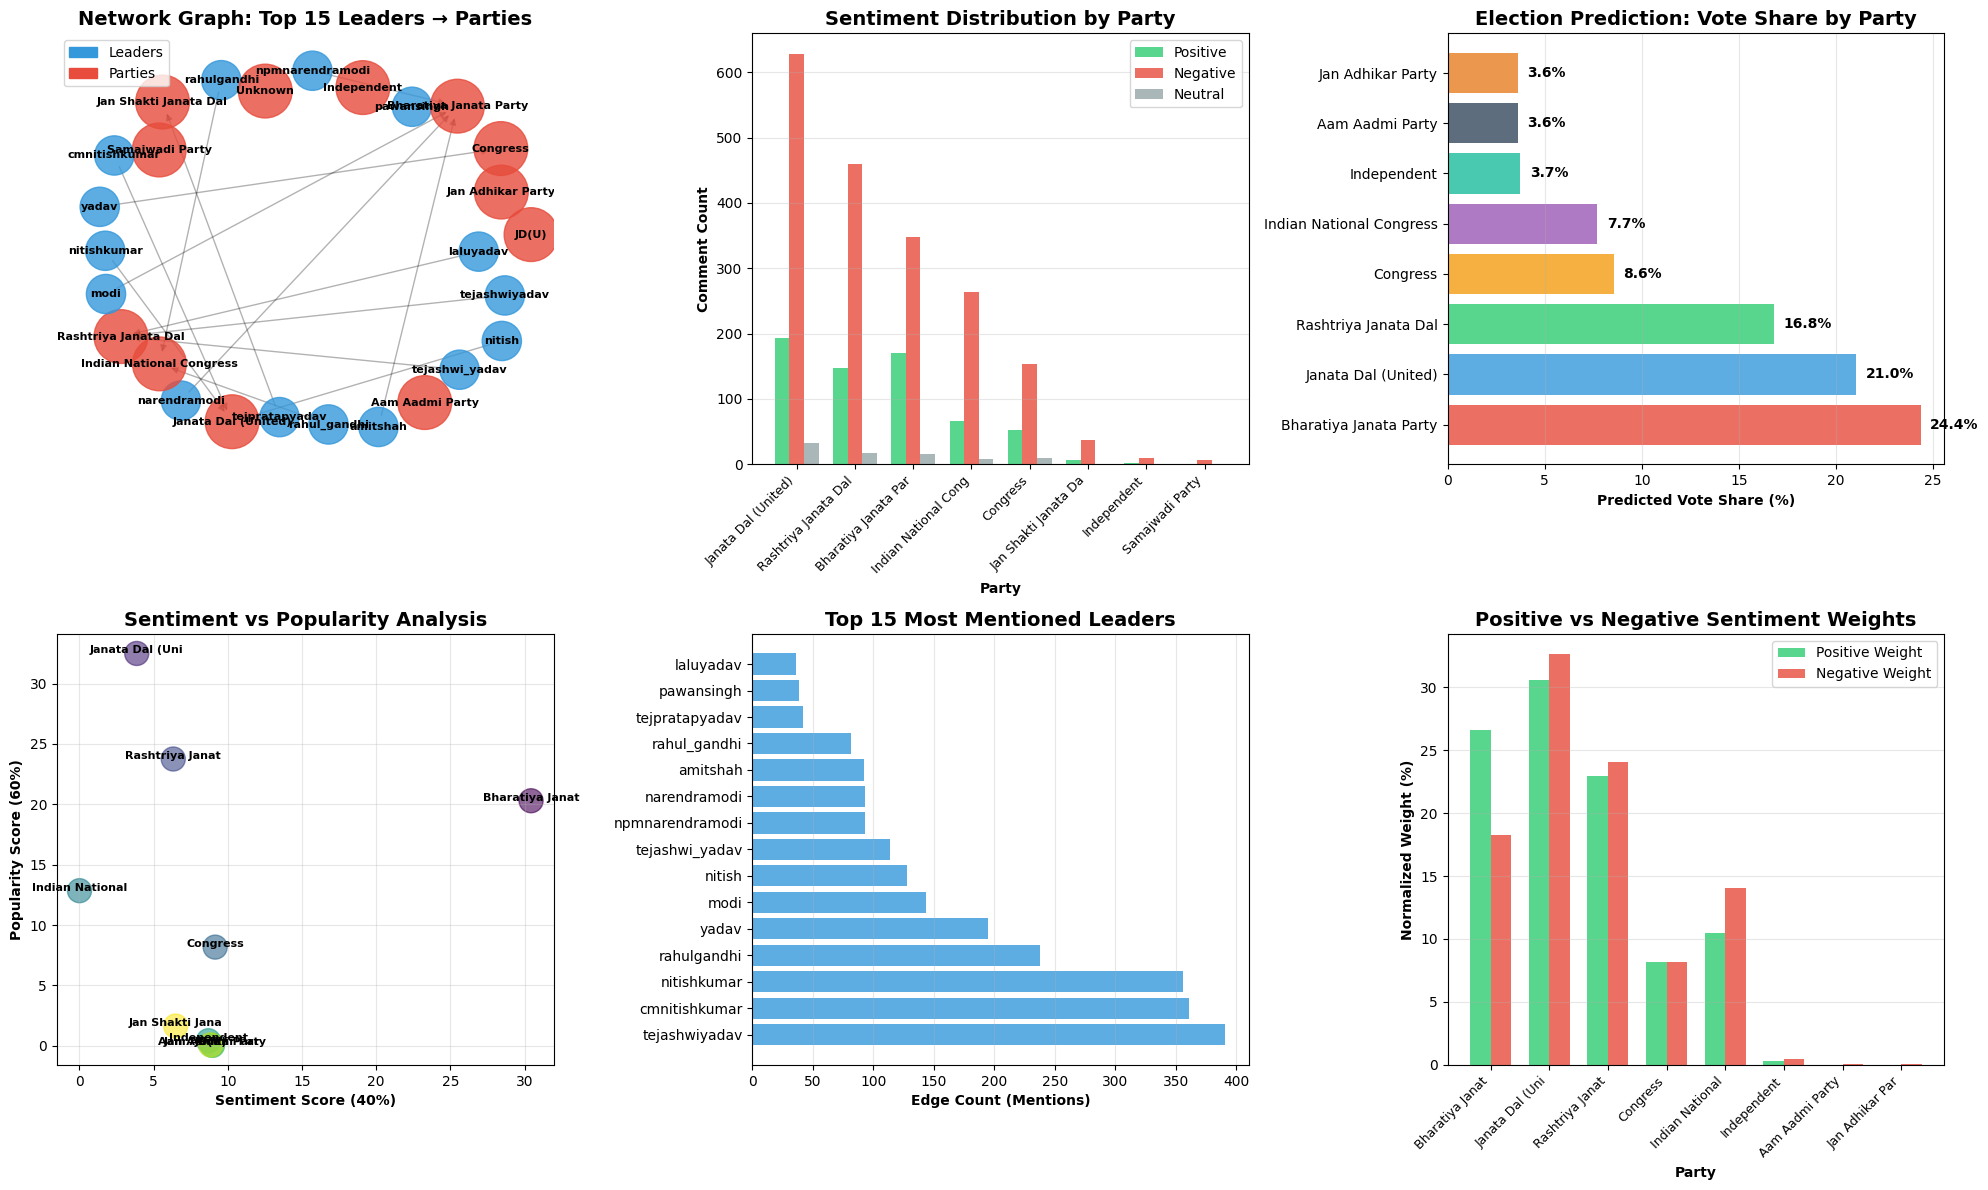


Visualization complete!


In [8]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import defaultdict
import numpy as np

# Load sentiment analysis results
sentiment_df = pd.read_csv('leader_sentiment_multilingual.csv')

print("Building graph and generating visualizations...")

# Create directed graph
G = nx.DiGraph()

# Normalized sentiment weight calculation
def get_normalized_sentiment_weight(sentiment, confidence):
    if sentiment == 'positive':
        return 0.5 + (confidence * 0.5)
    elif sentiment == 'negative':
        return -0.5 - (confidence * 0.5)
    else:
        return (confidence - 0.5) * 0.2

# Build graph with node types
user_nodes = set()
leader_nodes = set()
party_nodes = set()

for idx, row in sentiment_df.iterrows():
    user = f"user_{row['tweet_id']}"
    leader = row['leader']
    party = row['party']
    sentiment = row['sentiment']
    confidence = row['confidence_score']
    
    weight = get_normalized_sentiment_weight(sentiment, confidence)
    
    user_nodes.add(user)
    leader_nodes.add(leader)
    party_nodes.add(party)
    
    # Add user->leader edge
    if G.has_edge(user, leader):
        G[user][leader]['weight'] += weight
        G[user][leader]['count'] += 1
    else:
        G.add_edge(user, leader, weight=weight, count=1)

# Add leader->party edges
for leader in leader_nodes:
    party = sentiment_df[sentiment_df['leader'] == leader]['party'].iloc[0]
    if not G.has_edge(leader, party):
        G.add_edge(leader, party, weight=0, type='leader_to_party')

# Add node attributes for visualization
for node in G.nodes():
    if node in user_nodes:
        G.nodes[node]['type'] = 'user'
    elif node in leader_nodes:
        G.nodes[node]['type'] = 'leader'
    elif node in party_nodes:
        G.nodes[node]['type'] = 'party'

print(f"Graph created: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# Create visualizations
fig = plt.figure(figsize=(20, 12))

# ============================================================================
# VISUALIZATION 1: Simplified Network (Top Leaders and Parties Only)
# ============================================================================
print("Creating simplified network visualization...")
ax1 = plt.subplot(2, 3, 1)

# Create subgraph with top 15 leaders and parties only
leader_scores = {}
for leader in leader_nodes:
    incoming = list(G.in_edges(leader, data=True))
    edge_count = len(incoming)
    leader_scores[leader] = edge_count

top_leaders = sorted(leader_scores.items(), key=lambda x: x[1], reverse=True)[:15]
top_leader_names = [l[0] for l in top_leaders]

# Create subgraph
subgraph_nodes = set(top_leader_names) | party_nodes
G_sub = G.subgraph(subgraph_nodes)

# Layout
pos = nx.spring_layout(G_sub, k=2, iterations=50, seed=42)

# Node colors
node_colors = []
node_sizes = []
for node in G_sub.nodes():
    if G_sub.nodes[node]['type'] == 'leader':
        node_colors.append('#3498db')  # Blue for leaders
        node_sizes.append(800)
    else:  # party
        node_colors.append('#e74c3c')  # Red for parties
        node_sizes.append(1500)

# Draw
nx.draw_networkx_nodes(G_sub, pos, node_color=node_colors, node_size=node_sizes, alpha=0.8, ax=ax1)
nx.draw_networkx_edges(G_sub, pos, alpha=0.3, arrows=True, arrowsize=10, ax=ax1)
nx.draw_networkx_labels(G_sub, pos, font_size=8, font_weight='bold', ax=ax1)

ax1.set_title('Network Graph: Top 15 Leaders → Parties', fontsize=14, fontweight='bold')
ax1.axis('off')

# Legend
blue_patch = mpatches.Patch(color='#3498db', label='Leaders')
red_patch = mpatches.Patch(color='#e74c3c', label='Parties')
ax1.legend(handles=[blue_patch, red_patch], loc='upper left')

# ============================================================================
# VISUALIZATION 2: Party Sentiment Comparison
# ============================================================================
print("Creating party sentiment comparison...")
ax2 = plt.subplot(2, 3, 2)

# Calculate party scores
party_data = defaultdict(lambda: {'positive': 0, 'negative': 0, 'neutral': 0, 'total': 0})

for _, row in sentiment_df.iterrows():
    party = row['party']
    if party != 'Unknown':
        sentiment = row['sentiment']
        party_data[party][sentiment] += 1
        party_data[party]['total'] += 1

# Prepare data for plotting
parties = []
positive_counts = []
negative_counts = []
neutral_counts = []

for party, data in sorted(party_data.items(), key=lambda x: x[1]['total'], reverse=True)[:8]:
    parties.append(party[:20])  # Truncate long names
    positive_counts.append(data['positive'])
    negative_counts.append(data['negative'])
    neutral_counts.append(data['neutral'])

x = np.arange(len(parties))
width = 0.25

bars1 = ax2.bar(x - width, positive_counts, width, label='Positive', color='#2ecc71', alpha=0.8)
bars2 = ax2.bar(x, negative_counts, width, label='Negative', color='#e74c3c', alpha=0.8)
bars3 = ax2.bar(x + width, neutral_counts, width, label='Neutral', color='#95a5a6', alpha=0.8)

ax2.set_xlabel('Party', fontweight='bold')
ax2.set_ylabel('Comment Count', fontweight='bold')
ax2.set_title('Sentiment Distribution by Party', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(parties, rotation=45, ha='right', fontsize=9)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# ============================================================================
# VISUALIZATION 3: Vote Share Prediction
# ============================================================================
print("Creating vote share prediction chart...")
ax3 = plt.subplot(2, 3, 3)

# Load prediction results
try:
    prediction_df = pd.read_csv('graph_election_prediction_final.csv')
    parties_pred = prediction_df['party'].head(8).tolist()
    vote_shares = prediction_df['vote_share_final'].head(8).tolist()
    
    colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c', '#34495e', '#e67e22']
    
    ax3.barh(parties_pred, vote_shares, color=colors[:len(parties_pred)], alpha=0.8)
    ax3.set_xlabel('Predicted Vote Share (%)', fontweight='bold')
    ax3.set_title('Election Prediction: Vote Share by Party', fontsize=14, fontweight='bold')
    ax3.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, v in enumerate(vote_shares):
        ax3.text(v + 0.5, i, f'{v:.1f}%', va='center', fontweight='bold')
except:
    ax3.text(0.5, 0.5, 'Run prediction model first', ha='center', va='center', transform=ax3.transAxes)
    ax3.set_title('Election Prediction', fontsize=14, fontweight='bold')

# ============================================================================
# VISUALIZATION 4: Sentiment Score vs Popularity Score
# ============================================================================
print("Creating sentiment vs popularity scatter plot...")
ax4 = plt.subplot(2, 3, 4)

try:
    sentiment_scores = prediction_df['sentiment_score_normalized'].head(10).tolist()
    popularity_scores = prediction_df['popularity_score'].head(10).tolist()
    parties_scatter = prediction_df['party'].head(10).tolist()
    
    scatter = ax4.scatter(sentiment_scores, popularity_scores, s=300, alpha=0.6, 
                         c=range(len(sentiment_scores)), cmap='viridis')
    
    # Add party labels
    for i, party in enumerate(parties_scatter):
        ax4.annotate(party[:15], (sentiment_scores[i], popularity_scores[i]), 
                    fontsize=8, ha='center', fontweight='bold')
    
    ax4.set_xlabel('Sentiment Score (40%)', fontweight='bold')
    ax4.set_ylabel('Popularity Score (60%)', fontweight='bold')
    ax4.set_title('Sentiment vs Popularity Analysis', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3)
except:
    ax4.text(0.5, 0.5, 'Run prediction model first', ha='center', va='center', transform=ax4.transAxes)
    ax4.set_title('Sentiment vs Popularity', fontsize=14, fontweight='bold')

# ============================================================================
# VISUALIZATION 5: Top Leaders by Edge Count
# ============================================================================
print("Creating top leaders chart...")
ax5 = plt.subplot(2, 3, 5)

top_15_leaders = sorted(leader_scores.items(), key=lambda x: x[1], reverse=True)[:15]
leader_names = [l[0][:20] for l in top_15_leaders]
leader_counts = [l[1] for l in top_15_leaders]

ax5.barh(leader_names, leader_counts, color='#3498db', alpha=0.8)
ax5.set_xlabel('Edge Count (Mentions)', fontweight='bold')
ax5.set_title('Top 15 Most Mentioned Leaders', fontsize=14, fontweight='bold')
ax5.grid(axis='x', alpha=0.3)

# ============================================================================
# VISUALIZATION 6: Positive vs Negative Weights by Party
# ============================================================================
print("Creating positive vs negative weights chart...")
ax6 = plt.subplot(2, 3, 6)

try:
    parties_weight = prediction_df['party'].head(8).tolist()
    pos_weights = prediction_df['normalized_positive'].head(8).tolist()
    neg_weights = prediction_df['normalized_negative'].head(8).tolist()
    
    x = np.arange(len(parties_weight))
    width = 0.35
    
    bars1 = ax6.bar(x - width/2, pos_weights, width, label='Positive Weight', color='#2ecc71', alpha=0.8)
    bars2 = ax6.bar(x + width/2, neg_weights, width, label='Negative Weight', color='#e74c3c', alpha=0.8)
    
    ax6.set_xlabel('Party', fontweight='bold')
    ax6.set_ylabel('Normalized Weight (%)', fontweight='bold')
    ax6.set_title('Positive vs Negative Sentiment Weights', fontsize=14, fontweight='bold')
    ax6.set_xticks(x)
    ax6.set_xticklabels([p[:15] for p in parties_weight], rotation=45, ha='right', fontsize=9)
    ax6.legend()
    ax6.grid(axis='y', alpha=0.3)
except:
    ax6.text(0.5, 0.5, 'Run prediction model first', ha='center', va='center', transform=ax6.transAxes)
    ax6.set_title('Sentiment Weights', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('election_prediction_graphs.png', dpi=300, bbox_inches='tight')
print("\n✓ Graphs saved as: election_prediction_graphs.png")
plt.show()

print("\nVisualization complete!")
